In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold,cross_val_score

#Covid-19 Forecast in Indiana

The goal of this project is to predict the number of confirmed cases in the days ahead of us using regression. I will be using data gathered by Johns Hopkins that is based on the number of confirmed cases so far. I decided to limit my area of interest to the counties of Indiana.

###Preprocessing Data

The data consists of 11 attributes excluding the time series data.


*   UID: uinique id
*   iso2: country identifier
*   iso3: country identifier
*   code3: country identifier
*   FIPS: unique id for counties in US
*   Admin2: county name
*   Province_State: state name
*   Country_region: country name
*   Lat: latitude
*   Long_: longitude
*   Combined_Key: county, state, country combination
*   The other attributes are confirmed cases on that date.

I am going to filter out all of the attributes aside from the confirmed cases and the Admin2 attribute for clarity.



In [ ]:
#the data was acquired from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
myData = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

#acquired from http://www.stats.indiana.edu/population/popTotals/2017_cntyest.asp
countyPop = pd.read_csv("indianaCountyPopulation.csv")
#filtering out data not from indiana
myData = myData.loc[myData["Province_State"] == "Indiana"]
#lets filter out irrelevant location data since we are focused on counties in indiana
myData = myData.drop(columns=["UID","iso2","iso3","code3","FIPS","Province_State","Country_Region","Lat","Long_","Combined_Key"])
#transforming data for time series analysis
counties = myData.Admin2.values
transposedData = myData.loc[myData["Admin2"]=="Adams"].T
for county in counties:
  transposedData = pd.concat([transposedData, myData.loc[myData["Admin2"]==county].T], axis=1)
myData = transposedData.T.drop_duplicates().T

#cleaning up indices and removing extraneous data
myData = myData.drop(myData.index[0])
counties = np.delete(counties,[92,93])
myData = myData.iloc[:,0:92]
myData.columns = counties

#normalizing population data
for index,county in enumerate(counties):
    for j in range(0,len(myData["Adams"])):
      myData[county][j] = (myData[county][j]/countyPop.iat[index,1])*1000


#fig, ax = plt.subplots()
#for county in counties:
#    ax.plot(myData[county])
#plt.xticks(rotation=90)
#ax.xaxis.set_major_locator(ticker.MaxNLocator(8))
#ax.legend(counties,ncol=4,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#print(ax)

#above code chunk shows us lots of days with no cases in indiana
#so lets drop all data before 3/5 since its the day before the first confirmed case
myData = myData.drop(myData.index[0:43])
fig, ax = plt.subplots()
for county in counties:
    ax.plot(myData[county])
plt.xticks(rotation=90)
plt.title("Number of Confimred Cases by County in Indiana Per Day")
plt.xlabel("Date Confirmed")
plt.ylabel("Confirmed Cases(Normalized by Pop.)")
ax.xaxis.set_major_locator(ticker.MaxNLocator(8))
ax.legend(counties,ncol=4,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
print(ax)

###Modelling

Since most of our data appears to be linear although we know that is not the case in a pandemic, I will first be modelling using a simple linear regression model.

In [46]:
print()
numberOfDays = np.arange(1,len(myData["Adams"])+1)
myData['numberOfDays'] = numberOfDays

####Linear Model

In [ ]:
def linearModel(county):
  n = len(myData[county])
  X = np.array(myData["numberOfDays"].values)
  X = X.reshape(-1,1)
  y = np.array(myData[county].values)


  # Split the data into training/testing sets
  X_train = X[:-20]
  X_test = X[-20:]
  y_train = y[:-20]
  y_test = y[-20:]

  # Create linear regression object
  lm = linear_model.LinearRegression()

  # Train the model using the training sets
  lm.fit(X_train, y_train)

  # Make predictions using the testing set
  y_pred = lm.predict(X_test)

  # The mean squared error
  print('Mean squared error: {}'.format(mean_squared_error(y_test, y_pred)))
  # The coefficient of determination: 1 is perfect prediction
  print('Coefficient of determination: {}'.format(r2_score(y_test, y_pred)))
  # predict ten days in advance
  for x in range(1,11):
    # prediction
    print('Predicted: {}'.format(lm.predict(np.array([n+x]).reshape(-1,1))))

  # Plot outputs
  #plt.scatter(X_test, y_test,  color='black')
  #plt.plot(X_test, y_pred, color='blue', linewidth=3)
  #plt.xticks(())
  #plt.yticks(())
  #plt.show()



for county in counties:
  linearModel(county)
  print()

So we can see that the linear model just isnt cutting it. Even though on the inital analysis it looked as though the data had linear trends it is definetly not linear. Lets see if scaling the data to have a mean 0 and variance of 1 changes anything.

Scores: [0.90346406 0.85579528 0.91361173 0.90322046 0.89062099 0.87537942
 0.90369409 0.91775608 0.85564024 0.90520799 0.8831803  0.89267143
 0.92755832 0.87946184 0.84020251 0.90386621 0.89982711 0.88605964
 0.90817459 0.8982059  0.86030809 0.87917104 0.9201495  0.87679014
 0.88341802 0.90929061 0.8935455  0.90172114 0.90130168 0.90019984]

Scores: [0.94467827 0.91723886 0.94787684 0.94153885 0.93285788 0.91684195
 0.93897004 0.94819352 0.90797468 0.93956382 0.92552051 0.93420172
 0.95600544 0.92622103 0.90099601 0.94262234 0.93531704 0.93004978
 0.94276386 0.93789347 0.9150842  0.92041808 0.95221539 0.92361433
 0.92418007 0.94503746 0.93517858 0.94108423 0.94040519 0.93691339]

Scores: [0.92749683 0.89589728 0.93496239 0.92364711 0.91870305 0.89538969
 0.91931512 0.92949725 0.88780976 0.92333203 0.90778387 0.91795808
 0.94457515 0.91104245 0.87293088 0.92139339 0.92145522 0.9088891
 0.92798229 0.9143692  0.89486998 0.89890091 0.9436134  0.90302818
 0.90238315 0.92832844 0.91875374 0

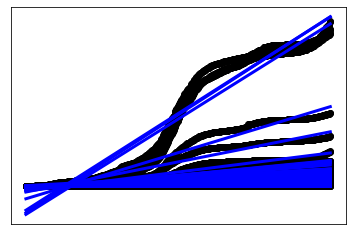

In [78]:
def ridgeRegression(county):
  n = len(myData[county])
  X = np.array(myData["numberOfDays"].values)
  X = X.reshape(-1,1)
  y = np.array(myData[county].values)

  # Create ridge regression object
  rm = Ridge()

  # Train the model using the training sets
  rm.fit(X,y)

  # KFold for cross validation
  cv = RepeatedKFold(n_splits=10,n_repeats=3,random_state=5)

  # Eval of model performance
  scores = cross_val_score(rm, X, y, scoring='r2', cv=cv, n_jobs=-1)
  print('Scores: {}'.format(scores))

  #for x in range(1,11):
  #  print('Predicted: {}'.format(rm.predict(np.array([n+x]).reshape(-1,1))))



  # Plot outputs
  #plt.scatter(X, y,  color='black')
  #plt.plot(X, rm.predict(X), color='blue', linewidth=3)
  #plt.xticks(())
  #plt.yticks(())
  #plt.show()



for county in counties:
  ridgeRegression(county)
  print()

#Conclusion

The Covid19 outbreak is difficult to use a general model for because of the widely varying circumstances that every region has. This model is not good at predicting cases because it cannot take into account the other extremely important factors such as infection rate, immunity rate, fatality rate and recovery rate. The models generated here for each county seem to be overfit or underfit because of these additional factors the dataset did not contain. With all that being said these models function well due to the fact that the number of cases continues to climb, when the number of cases ceases to grow and the line stagnates the models will begin to perform worse.

##Predictions
For the predictions of each county we can see a variety of things happening, the counties that are larger we can easily see the sharp upturn in cases, the smaller the county size the more gradual the slope. Meaning the larger the county is the faster the spread is which makes sense.

In [28]:
numberOfDays = np.arange(1,len(myData["Adams"])+1)
myData['numberOfDays'] = numberOfDays



Mean squared error: 9.85
Coefficient of determination: 0.19
